In [36]:
import cv2
import base64
import numpy as np
import matplotlib.pyplot as plt

## Image Preprocessing
---
TODO: Delte the duplicates in the beginning:
Therefore Identify the Beginning of the Line

In [60]:
preloaded_images = None
with open("preloaded_images.txt", "r") as file:
    preloaded_images = eval(file.read())
selected_diff_image = preloaded_images[2]

# Convert image
decoded_image = base64.b64decode(selected_diff_image.split(',')[1])
image_array = np.frombuffer(decoded_image, dtype=np.uint8)
origial = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

cropped = origial[100:110, 100:110]

edges = cv2.Canny(cropped, 100, 200)

In [61]:
# Erstelle einen leeren Hintergrund
background = np.zeros_like(edges)

# Finde die Kantenpixel im Originalbild
edge_pixels = np.where(edges != 0)

# Setze die Kanten im Hintergrund auf 255
background[edge_pixels] = 255

In [62]:
edges2 = np.array([[  0,   0,   0,   0,   0,   0,   0, 255,   0,   0],
       [  0,   0,   0,   0,   0,   0, 255,   0,   0,   0],
       [  0,   0,   0,   0,   0, 255,   0,   0,   0,   0],
       [  0,   0,   0, 255, 255,   0,   0,   0,   0,   0],
       [  0,   0,   0, 255,   0,   0,   0,   0,   0,   0],
       [  0,   0, 255,   0,   0,   0,   0,   0,   0,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

# edges2 = cv2.cvtColor(edges2.astype(np.uint8), cv2.COLOR_GRAY2CV_8UC1)

In [63]:
contours, _ = cv2.findContours(edges2.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Konturen in Kantenbild einzeichnen
# contour_image = np.copy(edges2)  # Kopie des Kantenbildes

# # Konturen mit markanter Farbe einzeichnen
# contour_image = cv2.drawContours(contour_image, contours, -1, 255, 1)

In [64]:
for contour in contours:
    contour_list = []
    for points in contour:
        contour_list.append([points[0][0], points[0][1]])
    
    print(contour_list)

[[7, 0], [4, 3], [3, 3], [3, 4], [1, 6]]


In [65]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
dilated = cv2.dilate(edges, kernel)
morph = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, kernel)

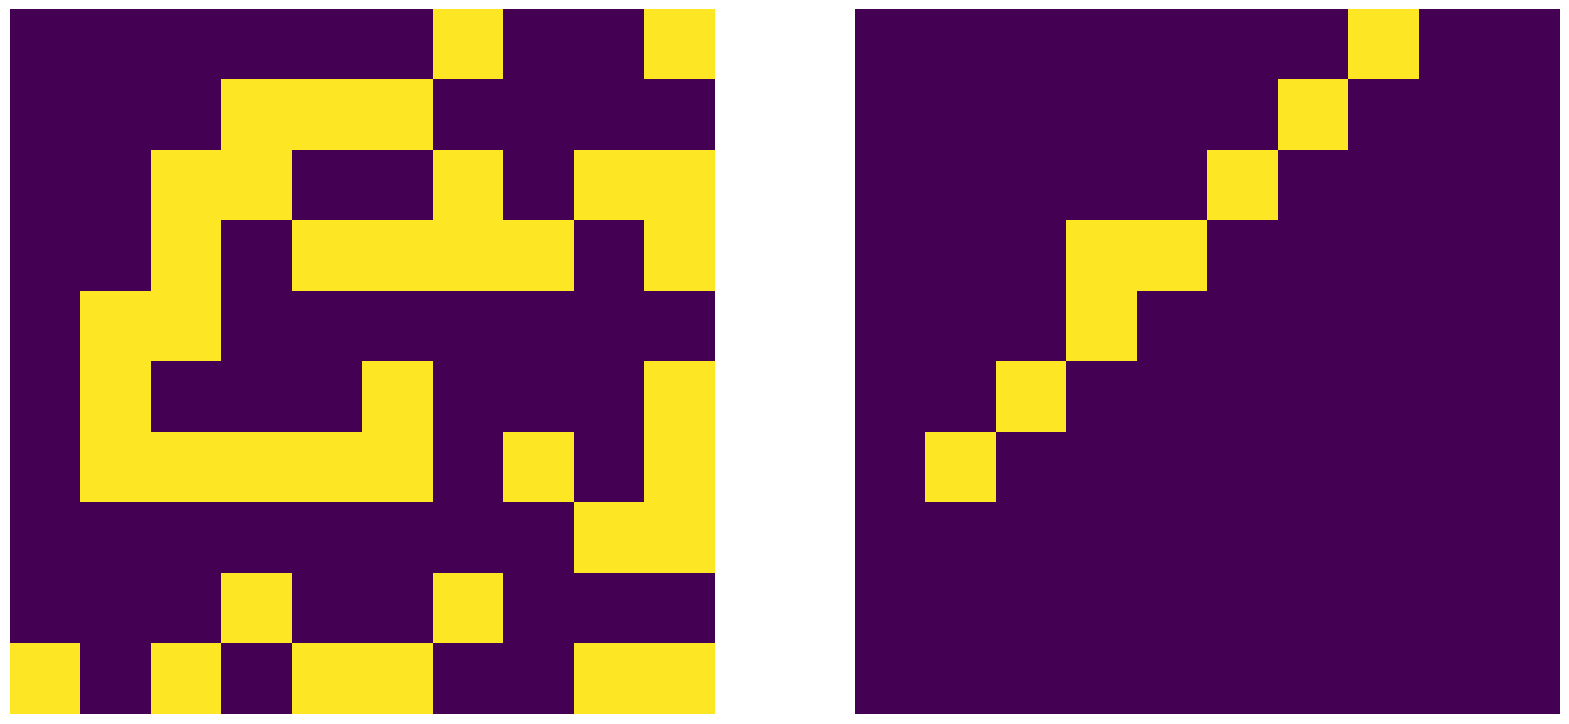

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(edges)
axes[0].axis('off')
axes[1].imshow(edges2)
axes[1].axis('off')
plt.show()

In [67]:
path = "gcode.tap"


z_safe_hight = 10.0
z_working_hight = 0.5
z_depth = 3
z_feed = 500
xy_feed = 1000
spindle_speed = 24000
def generate_gcode(contours):
    gcode_data = []

    # set contour to (0|0)
    minX = 1000
    maxX = 0
    minY = 1000
    maxY = 0

    for count, c in enumerate(contours):
        tmp_minX = np.min(c[:, :, 0])
        tmp_minY = np.min(c[:, :, 1])
        tmp_maxX = np.max(c[:, :, 0])
        tmp_maxY = np.max(c[:, :, 1])
        if tmp_minX < minX:
            minX = tmp_minX
        if tmp_minY < minY:
            minY = tmp_minY
        if tmp_maxX > maxX:
            maxX = tmp_maxX
        if tmp_maxY > maxY:
            maxY = tmp_maxY

    contours_lists = []
    for contour in contours:
        contour_list = []
        for points in contour:
            contour_list.append([points[0][0] - minX, points[0][1] - minY])

        contours_lists.append(contour_list)

    # write g-code
    gcode_start = [f"M03 S{spindle_speed}",
                   f"G00 Z{z_safe_hight}"]
    gcode_end = [f"G00 Z{z_safe_hight}", "G00 X0 Y0", "M05", "M30"]

    gcode_data = []

    for elem in gcode_start:
        gcode_data.append(f"{elem}\n")

    for contour in contours_lists:

        tmp_contour_len = len(contour)
        gcode_data.append(f"{tmp_contour_len}#####################################\n")

        gcode_data.append(f"G00 X{contour[0][0]} Y{contour[0][1]}\n")
        gcode_data.append(f"G00 Z0\n")
        gcode_data.append(f"G01 Z-{z_depth} F{z_feed}\n")

        if tmp_contour_len == 2:
            gcode_data.append(
                f"G01 X{contour[1][0]} Y{contour[1][1]} F{xy_feed}\n")

        gcode_data.append(f"G00 Z{z_working_hight}\n")

        if tmp_contour_len > 2:
            for i in range(tmp_contour_len-1):
                if i == 0:
                    gcode_data.append(
                        f"G01 X{contour[i+1][0]} Y{contour[i+1][1]} F{xy_feed}\n")
                else:
                    gcode_data.append(
                        f"G01 X{contour[i+1][0]} Y{contour[i+1][1]}\n")
            gcode_data.append(f"G00 Z{z_working_hight}\n")

    for elem in gcode_end:
        gcode_data.append(f"{elem}\n")

    # return gcode_data
    # Save the G-code to a file
    with open(path, "w") as f:
        f.writelines(gcode_data)

def get_contours(dilated, contour_minArcLength=0):
    contours, _ = cv2.findContours(dilated, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    final_contours = []
    for c in contours:
        areaContour = cv2.arcLength(c, True)
        area_min = contour_minArcLength
        area_max = 1000000000
        if areaContour < area_min or area_max < areaContour:
            continue
        else:
            final_contours.append(c)
    return final_contours

def image_to_gcode(img):
    # resized_image = cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4))
    resized_image = img
    return generate_gcode(get_contours(resized_image))

In [69]:
image_to_gcode(edges2.astype(np.uint8))